In [208]:
!pip install umap
!pip install kneed

In [209]:
import doctest
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.neighbors import NearestNeighbors
# from geopy.distance import geodesic
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
#from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as cluster
from kneed import KneeLocator
from sklearn.model_selection import ParameterGrid
from sklearn.mixture import GaussianMixture
from sklearn.cluster import HDBSCAN
# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")

In [210]:
plt.style.use('dark_background')

### Read in the data

In [211]:
housing_data_df = pd.read_csv(r'clean_housing_data_with_crime_rates.csv')
housing_data_df

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,...,house_coordinates,closest_city,city_coordinates,distance_to_maj_city_miles,population_y,violent_crime,prop_crime,larceny,vehicle_theft,difference_listed_vs_estimate
0,AL,Montgomery,Brampton Ln,36117.0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,...,"(32.372746, -86.165115)",Birmingham,"(33.5279, -86.7971)",87.664428,209018.0,0.001893,0.027600,0.017277,0.002520,500.0
1,AL,Montgomery,Crestview Ave,36109.0,3.0,2.0,2196.0,76.958106,0.6100,124700.0,...,"(32.39595, -86.269714)",Birmingham,"(33.5279, -86.7971)",83.806091,209018.0,0.001893,0.027600,0.017277,0.002520,44300.0
2,AL,Montgomery,Narrow Lane Rd,36116.0,3.0,3.0,3693.0,54.156512,6.9000,188300.0,...,"(32.273514, -86.25934)",Birmingham,"(33.5279, -86.7971)",91.920847,209018.0,0.001893,0.027600,0.017277,0.002520,11700.0
3,AL,Montgomery,E Delano Ave,36105.0,3.0,2.0,1428.0,90.966387,0.2600,127500.0,...,"(32.337, -86.29974)",Birmingham,"(33.5279, -86.7971)",87.007986,209018.0,0.001893,0.027600,0.017277,0.002520,2400.0
4,AL,Montgomery,George B Edmondson Dr,36110.0,3.0,1.0,1050.0,65.714286,0.1600,66500.0,...,"(32.40325, -86.28537)",Birmingham,"(33.5279, -86.7971)",83.007626,209018.0,0.001893,0.027600,0.017277,0.002520,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,WY,Green River,Colorado Dr,82935.0,5.0,3.0,3068.0,128.748370,0.2200,381000.0,...,"(41.494328, -109.45258)",Provo,"(40.2457, -111.6457)",143.591563,11927.0,0.001845,0.008133,0.007043,0.000168,14000.0
9632,WY,Evansville,Henrie Roadway,82636.0,2.0,2.0,2008.0,343.625498,4.6000,689900.0,...,"(42.86057, -106.10931)",Denver,"(39.762, -104.8758)",223.247715,2977.0,0.002351,0.024521,0.017467,0.002687,100.0
9633,WY,Evansville,6th St,82636.0,4.0,2.0,2022.0,157.270030,0.1828,311100.0,...,"(42.86506, -106.27643)",Denver,"(39.762, -104.8758)",226.191583,2977.0,0.002351,0.024521,0.017467,0.002687,6900.0
9634,WY,Evansville,6th St,82636.0,3.0,3.0,2300.0,143.434783,0.1739,329500.0,...,"(42.86544, -106.27745)",Denver,"(39.762, -104.8758)",226.233434,2977.0,0.002351,0.024521,0.017467,0.002687,400.0


In [212]:
# manipulating coordinates to be two separate variables + in separate columns for location purposes
housing_df_revised = housing_data_df[['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate', 'house_coordinates', 'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny', 'vehicle_theft']]
housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
housing_df_revised['x_house_coord'] = housing_df_revised['x_house_coord'].astype(float)
housing_df_revised['y_house_coord'] = housing_df_revised['y_house_coord'].astype(float)
housing_df_revised.drop(columns=['house_coordinates'], inplace=True)

/var/folders/j6/1p36544j2r30zl97tfywsd3h0000gn/T/ipykernel_1601/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
/var/folders/j6/1p36544j2r30zl97tfywsd3h0000gn/T/ipykernel_1601/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['ho

In [213]:
housing_df_revised.columns

Index(['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate',
       'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate',
       'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny',
       'vehicle_theft', 'x_house_coord', 'y_house_coord'],
      dtype='object')

In [214]:
for var in housing_df_revised.columns:
    print(type(housing_df_revised[var][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [215]:
housing_df_matrix = housing_df_revised.values
housing_df_matrix

array([[ 3.00000000e+00,  2.00000000e+00,  1.56400000e+03, ...,
         2.51987867e-03,  3.23727460e+01, -8.61651150e+01],
       [ 3.00000000e+00,  2.00000000e+00,  2.19600000e+03, ...,
         2.51987867e-03,  3.23959500e+01, -8.62697140e+01],
       [ 3.00000000e+00,  3.00000000e+00,  3.69300000e+03, ...,
         2.51987867e-03,  3.22735140e+01, -8.62593400e+01],
       ...,
       [ 4.00000000e+00,  2.00000000e+00,  2.02200000e+03, ...,
         2.68726906e-03,  4.28650600e+01, -1.06276430e+02],
       [ 3.00000000e+00,  3.00000000e+00,  2.30000000e+03, ...,
         2.68726906e-03,  4.28654400e+01, -1.06277450e+02],
       [ 4.00000000e+00,  2.00000000e+00,  2.12000000e+03, ...,
         2.51572327e-03,  4.28510060e+01, -1.06391810e+02]])

In [216]:
housing_df_matrix.shape

(9636, 16)

### Scale the data

In [217]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
housing_df_matrix_scaled = StandardScaler().fit_transform(housing_df_matrix)

### UMAP Reduction

In [218]:
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.1, metric='euclidean',random_state=99)
umap_result = umap_model.fit_transform(housing_df_matrix_scaled)

/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


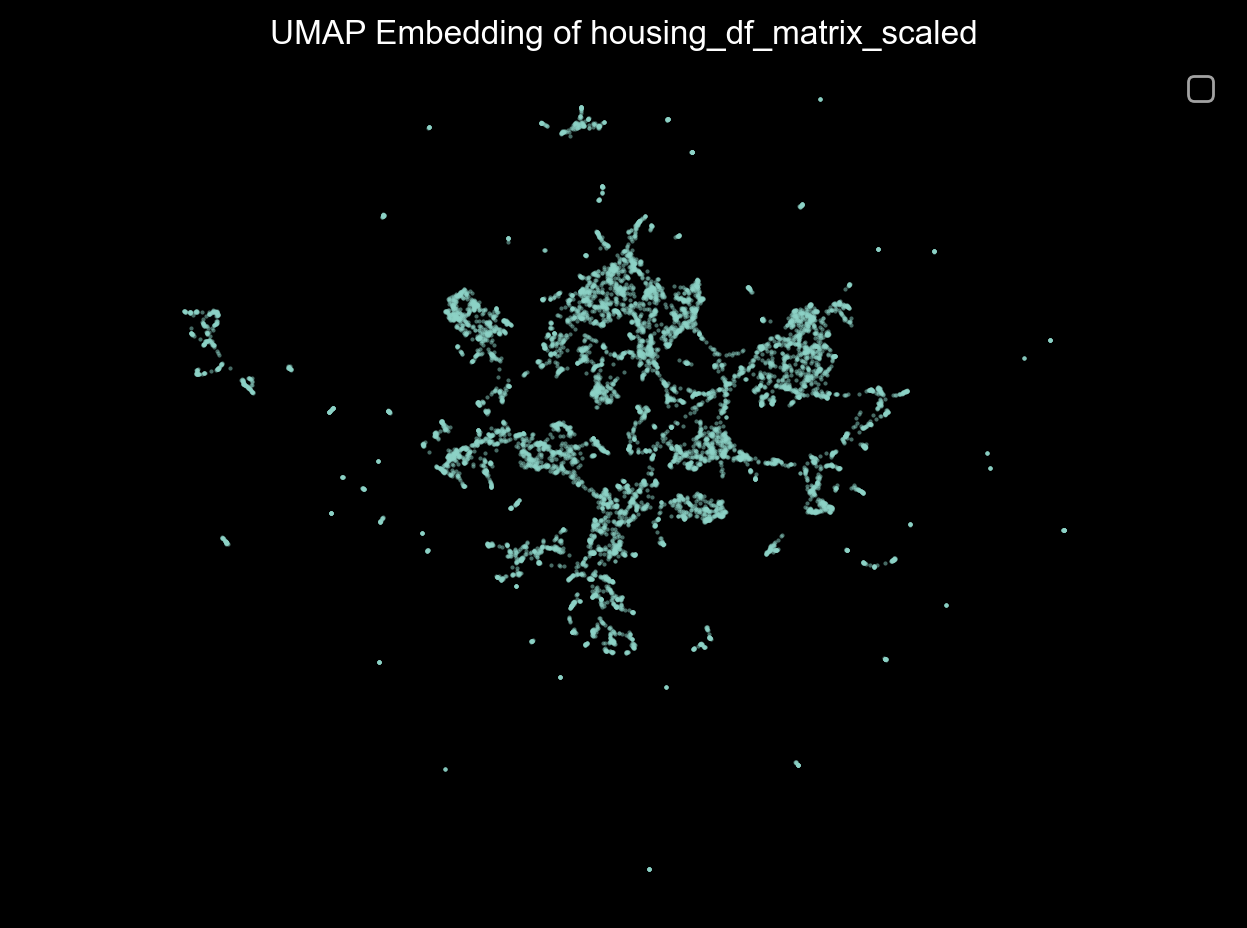

In [219]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='.', alpha=0.5, s = 1)
plt.title('UMAP Embedding of housing_df_matrix_scaled')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.axis("off")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


# Generate clusters

## GMM

In [220]:
range_n_clusters = [2 ,3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters)
    clusterer.fit(umap_result)
    cluster_labels = clusterer.predict(umap_result)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(umap_result, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.34215525
For n_clusters = 3 The average silhouette_score is : 0.3276774
For n_clusters = 4 The average silhouette_score is : 0.28755286
For n_clusters = 5 The average silhouette_score is : 0.33084172
For n_clusters = 6 The average silhouette_score is : 0.3901151
For n_clusters = 7 The average silhouette_score is : 0.37162262
For n_clusters = 8 The average silhouette_score is : 0.3584414
For n_clusters = 9 The average silhouette_score is : 0.39738607
For n_clusters = 10 The average silhouette_score is : 0.40290532


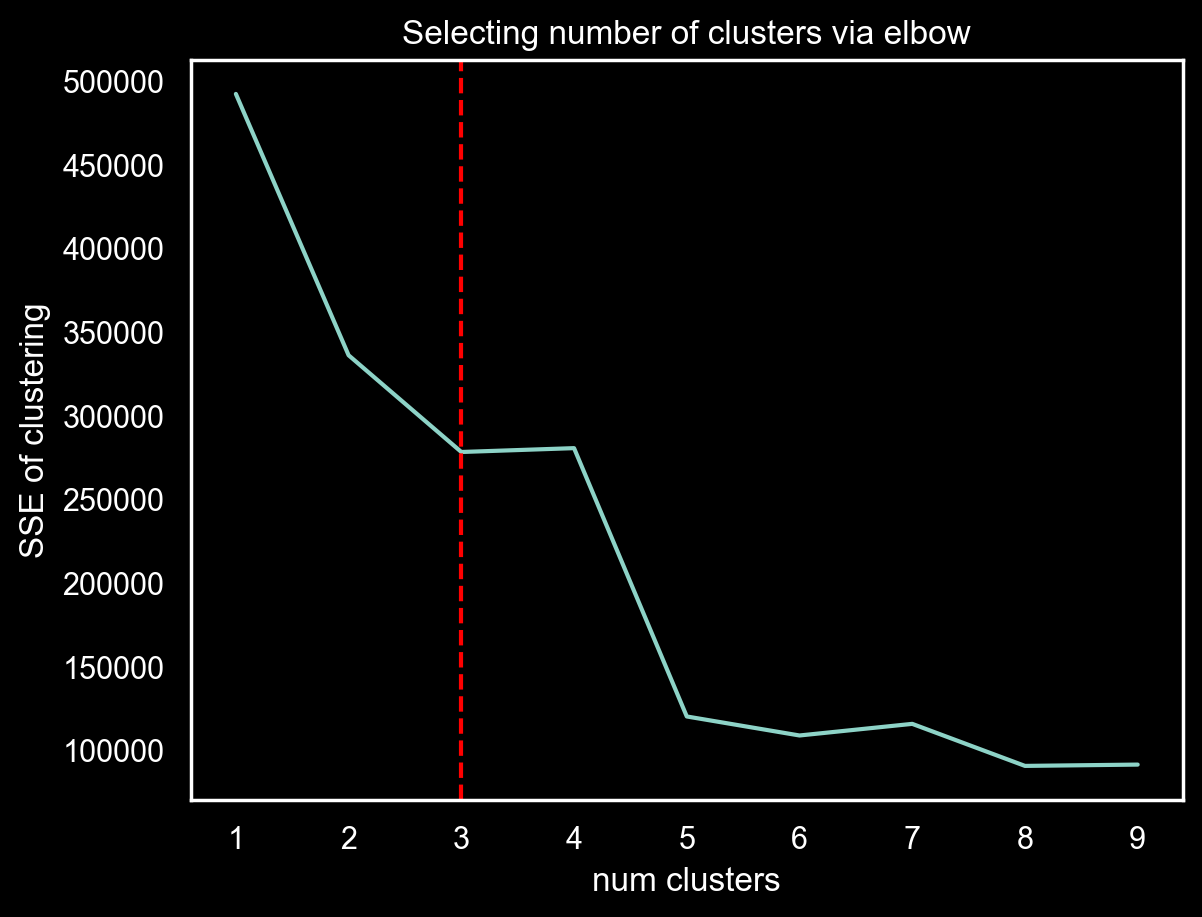

In [221]:
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = GaussianMixture(n_components=k)
    clust.fit(umap_result)
    
    distances = []
    for i, center in enumerate(clust.means_):
        distances.append(np.sum((umap_result[clust.predict(umap_result) == i] - center) ** 2))
    
    # Sum the squared distances to get the SSE
    sse.append(np.sum(distances)) 

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

In [222]:
# try 5 clusters
clusterer_gmm = GaussianMixture(n_components=5)
clusterer_gmm.fit(umap_result)
cluster_labels_gmm = clusterer_gmm.predict(umap_result)

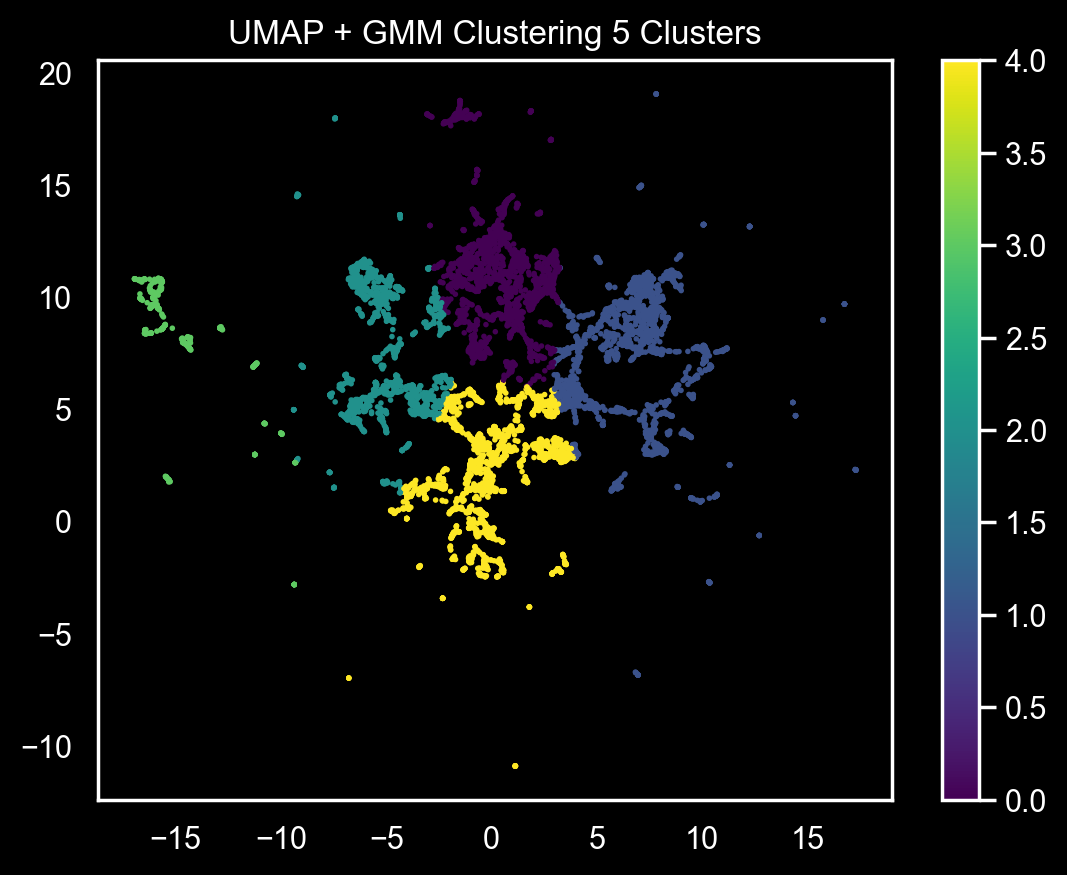

In [223]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_gmm, cmap='viridis', s = 1)
plt.title('UMAP + GMM Clustering 5 Clusters')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [224]:
housing_df_revised['gmm clusters'] = cluster_labels_gmm
housing_df_revised

/var/folders/j6/1p36544j2r30zl97tfywsd3h0000gn/T/ipykernel_1601/1598159889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['gmm clusters'] = cluster_labels_gmm


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,1
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,1
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,2
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,1
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,0
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,2
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2


In [225]:
housing_df_revised.groupby('gmm clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord
gmm clusters,,,,,,,,,,,,,,,,
0,4.337954,3.286486,2997.849980,208.272881,2.029863,706552.996331,3675.185079,733751.914798,27198.918467,86.684347,0.004288,0.023356,0.017345,0.002171,39.282650,-92.378695
1,3.260258,2.160695,1818.362462,244.043905,1.017930,442173.068769,2339.414894,443146.134878,973.066109,89.217192,0.003029,0.019201,0.014487,0.001657,38.931847,-95.462200
2,2.911640,2.217725,1798.585185,216.470851,0.630558,365628.995767,2070.604233,368958.315344,3329.319577,136.643602,0.003151,0.024792,0.019162,0.002063,41.802366,-100.741184
3,3.309168,2.420043,2036.699360,230.599418,0.921784,446030.063966,2557.622601,454828.347548,8798.283582,1113.927291,0.007264,0.038307,0.028887,0.004041,56.459503,-139.052137
4,3.240876,2.075411,1805.522354,174.872535,0.673366,300565.967153,1960.582573,305187.518704,4621.551551,66.879254,0.006299,0.042876,0.031842,0.003944,36.792999,-90.852462


In [226]:
# check how many points are in each cluster
for i in housing_df_revised['gmm clusters'].unique():
    shape = housing_df_revised[housing_df_revised['gmm clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 1 has 2632 observations
Cluster 2 has 1890 observations
Cluster 4 has 2192 observations
Cluster 0 has 2453 observations
Cluster 3 has 469 observations


## K-means

In [227]:
from sklearn.cluster import KMeans
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(umap_result)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(umap_result, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.354226


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.3789697


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.41508695


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.41405937


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.40343124


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.42533422


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.42993575


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 The average silhouette_score is : 0.44865093


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.4429465


/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.

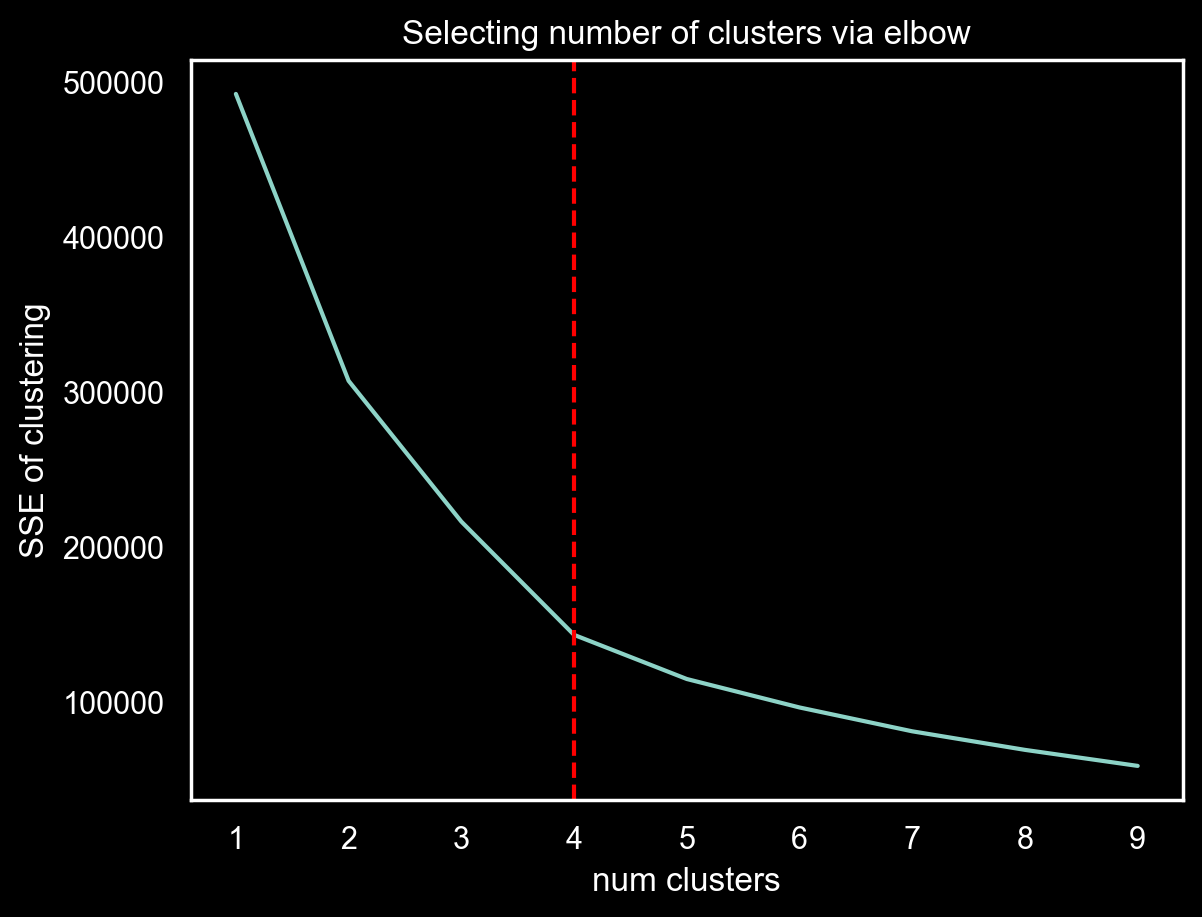

In [228]:
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(umap_result)
    sse.append(clust.inertia_)

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

In [229]:
# try 5 clusters
clusterer_kmeans = cluster.KMeans(n_clusters=5, random_state=10)
cluster_labels_kmeans = clusterer_kmeans.fit_predict(umap_result)

/Users/colin/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


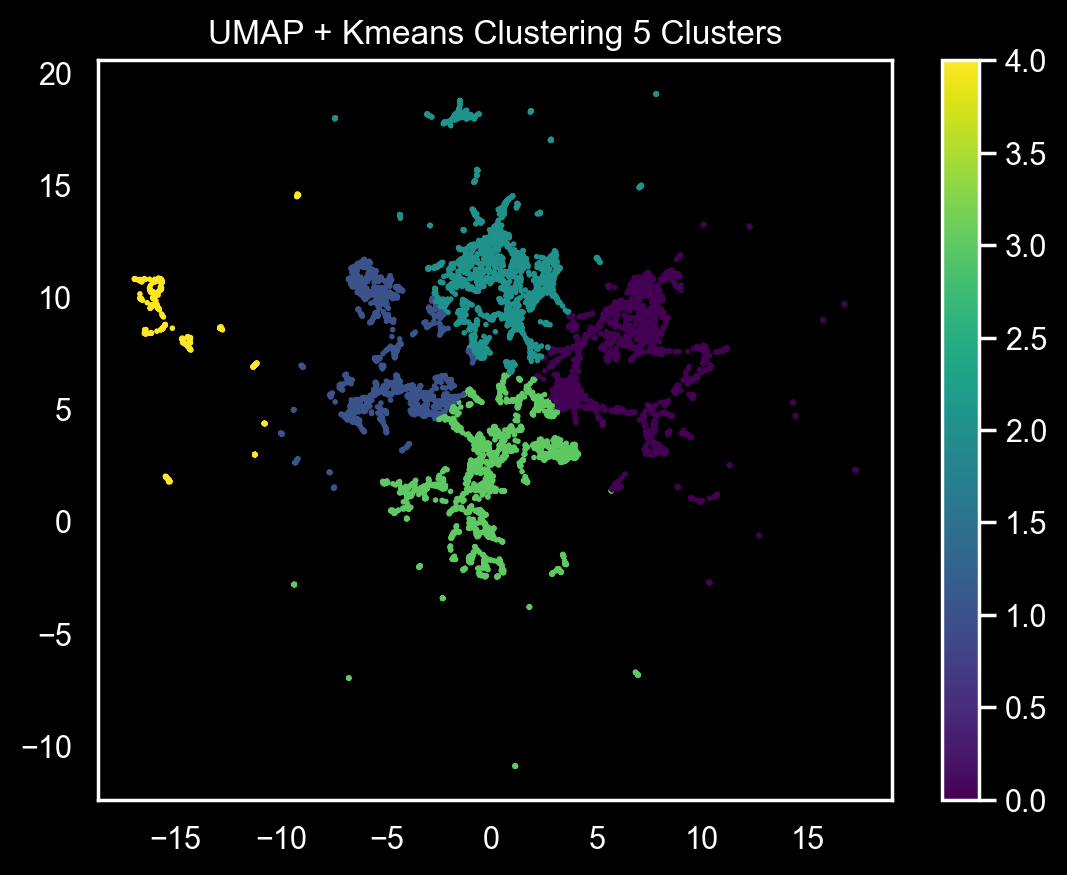

In [230]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_kmeans, cmap='viridis', s = 1)
plt.title('UMAP + Kmeans Clustering 5 Clusters')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [231]:
housing_df_revised['kmeans clusters'] = cluster_labels_kmeans
housing_df_revised

/var/folders/j6/1p36544j2r30zl97tfywsd3h0000gn/T/ipykernel_1601/757905298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['kmeans clusters'] = cluster_labels_kmeans


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,1,0
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,1,0
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,2,1
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,1,0
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,0,2
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,2,1
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2,1
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2,1


In [232]:
housing_df_revised.groupby('kmeans clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters
kmeans clusters,,,,,,,,,,,,,,,,,
0,3.271423,2.171171,1829.552152,241.617035,1.034245,439342.503684,2332.416828,440222.112834,879.609151,87.784736,0.002989,0.018800,0.014241,0.001635,38.984156,-95.292608,1.012408
1,2.845572,2.206803,1778.893089,218.471223,1.077510,363510.691145,2061.914687,366949.395248,3438.704104,132.072389,0.002994,0.023842,0.018427,0.001935,41.738055,-100.022017,2.049136
2,4.345133,3.283890,2989.568383,210.313745,1.696077,707111.706356,3665.391392,734100.424377,26988.718021,93.176902,0.004153,0.023709,0.017689,0.002190,39.336881,-92.851512,0.080451
3,3.254305,2.068565,1802.897130,175.707889,0.640243,303826.799117,1975.580132,308147.617660,4320.818543,65.417904,0.006547,0.042957,0.031756,0.004010,36.813562,-91.484506,3.816336
4,3.306167,2.398678,2033.799559,231.852841,0.945092,448696.035242,2560.158590,458193.189427,9497.154185,1154.052317,0.007162,0.039113,0.029690,0.003961,57.162937,-140.054315,2.944934


In [233]:
# check how many points are in each cluster
for i in housing_df_revised['kmeans clusters'].unique():
    shape = housing_df_revised[housing_df_revised['kmeans clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 0 has 2579 observations
Cluster 1 has 1852 observations
Cluster 3 has 2265 observations
Cluster 2 has 2486 observations
Cluster 4 has 454 observations


## DBSCAN

eps: 0.1, min_samples: 9
number of cluster : 342
number of noise : 2829
eps: 0.1, min_samples: 10
number of cluster : 300
number of noise : 3431
eps: 0.1, min_samples: 11
number of cluster : 271
number of noise : 3949
eps: 0.1, min_samples: 12
number of cluster : 228
number of noise : 4550
eps: 0.125, min_samples: 9
number of cluster : 321
number of noise : 1666
eps: 0.125, min_samples: 10
number of cluster : 300
number of noise : 2058
eps: 0.125, min_samples: 11
number of cluster : 280
number of noise : 2596
eps: 0.125, min_samples: 12
number of cluster : 259
number of noise : 3035
eps: 0.15, min_samples: 9
number of cluster : 263
number of noise : 990
eps: 0.15, min_samples: 10
number of cluster : 264
number of noise : 1239
eps: 0.15, min_samples: 11
number of cluster : 257
number of noise : 1597
eps: 0.15, min_samples: 12
number of cluster : 245
number of noise : 2018
eps: 0.175, min_samples: 9
number of cluster : 199
number of noise : 572
eps: 0.175, min_samples: 10
number of clust

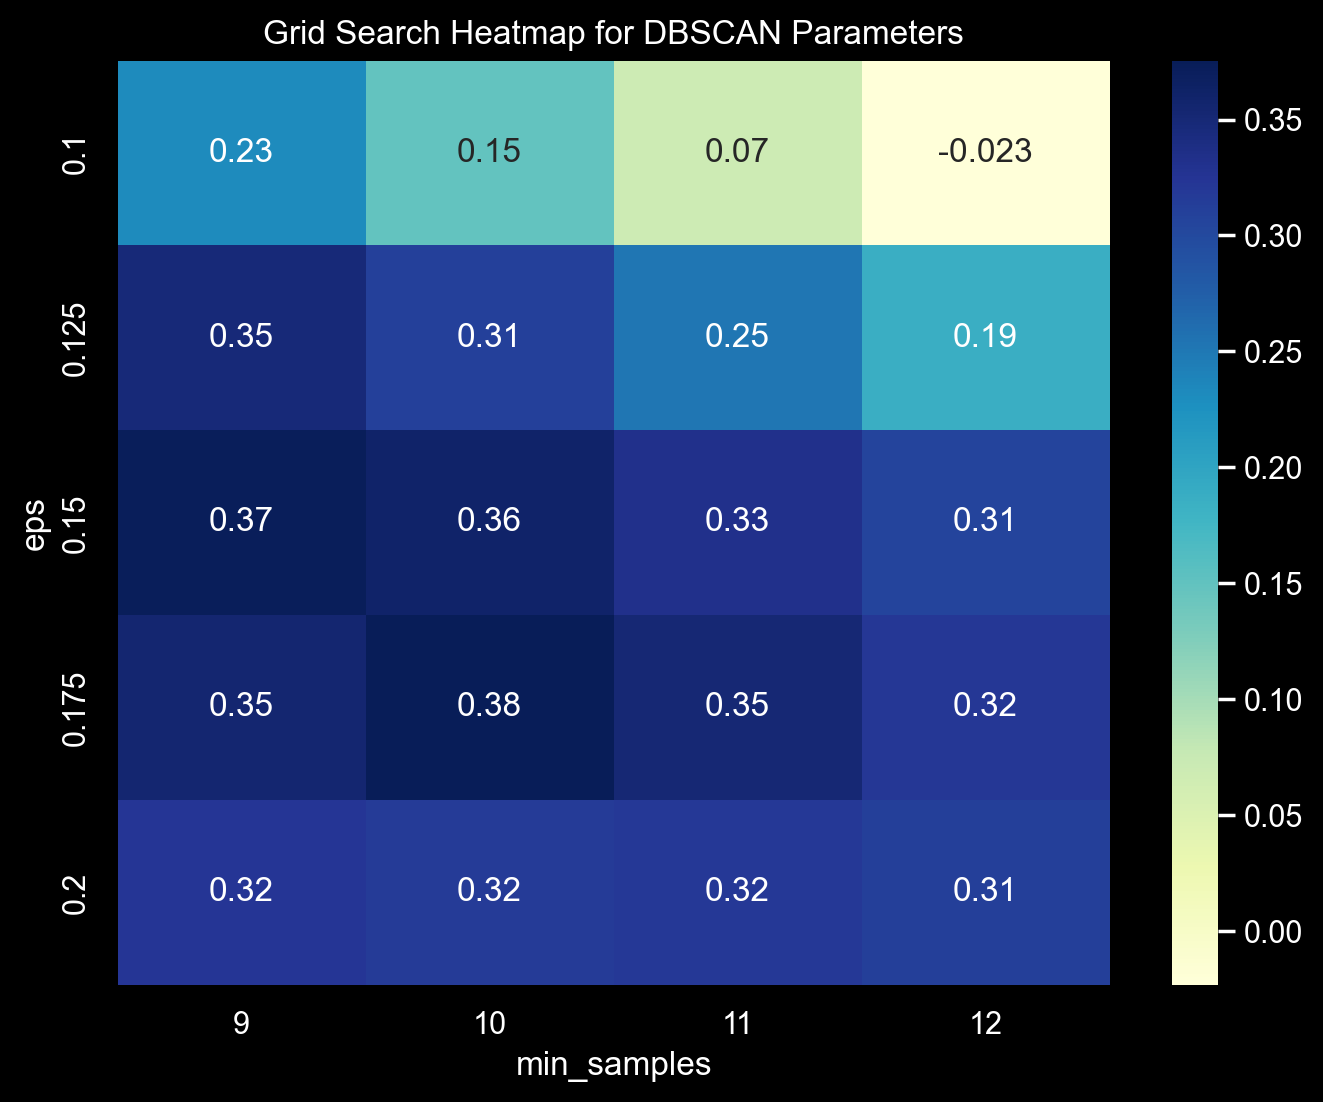

In [234]:
# decide parameters using gridsearch
# Define parameter grid
param_grid = {'eps': [0.1, 0.125, 0.15, 0.175, 0.2],
              'min_samples': [9, 10, 11, 12]}

# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['eps']), len(param_grid['min_samples'])))

# Iterate over parameter combinations
for i, params in enumerate(ParameterGrid(param_grid)):
    # Fit DBSCAN with current parameter combination
    dbscan = DBSCAN(**params)
    dbscan.fit(umap_result)
    labels = dbscan.fit_predict(umap_result)
    n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    eps_value = params['eps']
    min_samples_value = params['min_samples']
    
    print(f"eps: {eps_value}, min_samples: {min_samples_value}")
    print (f'number of cluster : {n_clusters_}')
    print (f'number of noise : {n_noise_}')
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(umap_result, dbscan.labels_)
    silhouette_scores[i // len(param_grid['min_samples']), i % len(param_grid['min_samples'])] = silhouette_avg

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['min_samples'], yticklabels=param_grid['eps'])
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Grid Search Heatmap for DBSCAN Parameters')
plt.show()


In [235]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=9)
cluster_labels_dbscan = dbscan.fit_predict(umap_result)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


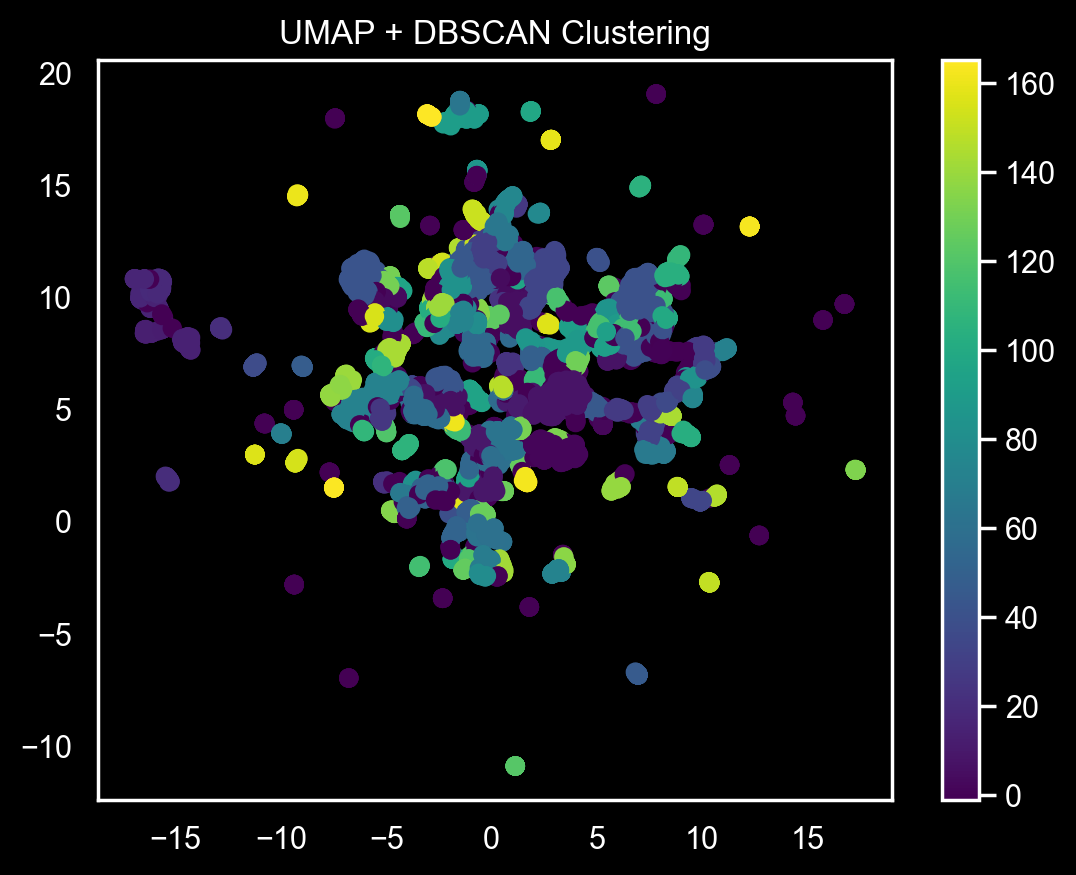

In [236]:
# plotting the clusters
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis')
plt.title('UMAP + DBSCAN Clustering')
plt.colorbar()
plt.show()


#### Look at dataframe to see if clusters make sense

In [237]:
housing_df_revised['dbscan clusters'] = cluster_labels_dbscan
housing_df_revised

/var/folders/j6/1p36544j2r30zl97tfywsd3h0000gn/T/ipykernel_1601/3665469015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['dbscan clusters'] = cluster_labels_dbscan


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters,dbscan clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,1,0,0
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,1,0,0
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,2,1,3
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,1,0,0
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,0,2,43
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,2,1,12
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2,1,138
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2,1,137
